In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys, json, os
sys.path.append('..')
from project.constants import Constants as pc
from project.recoil import Nuclear as Nr
from project.recoil import get_vdf_ert
import pickle

import warnings
warnings.filterwarnings("ignore", message="Attempt to set non-positive ylim on a log-scaled axis will be ignored.")

In [2]:
MW_dict = pickle.load(open('../Output/MW_dict.pkl','rb'))
mwd = MW_dict['vdf_RCfit']

# 1. Find the Benchmark scenario ($m,\, \sigma_p,\, E_\mathrm{thr},\, \omega)$

In [3]:
Mdm = np.logspace(0,1,100)
p50 = lambda x: np.percentile(x, 50)

def get_excl(nr, Ethr, ω):
    Sdm_1 = []
    for i, mdm in enumerate(Mdm):
        Ntot_0 = nr.totN(mdm, 1e-46, E = nr.E, Ethr = Ethr, ω = ω)
        Ntot_0 = 1e-5 if Ntot_0 == 0 else Ntot_0
        Sdm_1.append(1e-46/Ntot_0)
    return [Mdm, Sdm_1]

def get_Ntot(Sdm_1):
    Sdm = np.logspace(-48, -44, 100)

    Mdm_grid = np.zeros([100, 100])
    Sdm_grid = np.zeros(Mdm_grid.shape)
    Ntot_grid = np.zeros(Mdm_grid.shape)

    for i, mdm in enumerate(Mdm):
        for j, sdm in enumerate(Sdm):
            Mdm_grid[i,j] = mdm
            Sdm_grid[i,j] = sdm
            Ntot_grid[i,j] = sdm/Sdm_1[i]

    return [[Mdm_grid, Sdm_grid], Ntot_grid]

In [4]:
nr = Nr('Xe', mwd['vE'], mwd['vdfE_50'], p50(mwd['vescs']), p50(mwd['vcircs']), p50(mwd['rhosuns']))
Mdm_1, Sdm_1 = get_excl(nr, Ethr = 1, ω = 1)
grid_1, Z_1 = get_Ntot(Sdm_1)

Mdm_10, Sdm_10 = get_excl(nr, Ethr = 0.1, ω = 10)
grid_10, Z_10 = get_Ntot(Sdm_10)

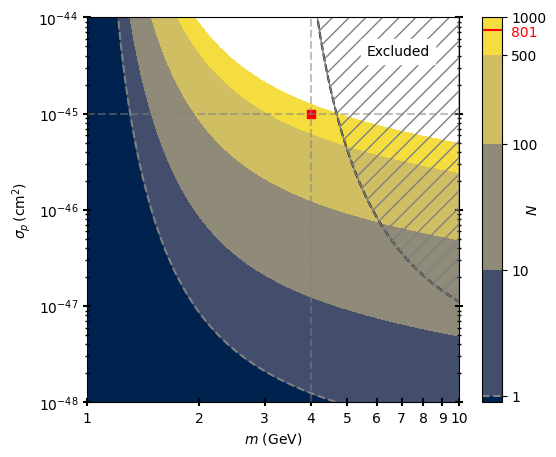

In [5]:
fig, ax = plt.subplots(figsize = (6,5))

ax.plot(Mdm_1, Sdm_1, c = 'k', ls = '--')
ax.fill_between(Mdm_1, Sdm_1, np.ones(Mdm_1.shape)*1e-40, color = 'grey', hatch = '//', facecolor = 'None',zorder = 2)
ax.text(0.75, 0.9, 'Excluded', backgroundcolor = 'white', transform = ax.transAxes)

cn = ax.contourf(*grid_10, Z_10, levels = [0, 1, 10, 100, 500, 1000], norm = "log", cmap = 'cividis')
cbar = fig.colorbar(cn, format = '%i')
ax.plot(Mdm_10, Sdm_10, c = 'grey', ls = '--')

ax.set_xlabel('$m$ (GeV)')
ax.set_ylabel('$\sigma_p \, (\mathrm{cm}^2)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-48, 1e-44)

ax.set_xticks([1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]);
ax.tick_params(axis = 'both', which = 'both', right = True, left = True, direction = 'inout')
ax.tick_params(which = 'major', width = 1.5, length = 6)
ax.tick_params(which = 'minor', width = 1, length = 3)

m,sp = 4, 1e-45
ax.scatter(m, sp, c = 'r', marker = 's', s = 30)

ax.plot([m,m],[1e-48,1e-44], c = 'grey', ls = '--', alpha = 0.5)
ax.plot([1,10], [sp,sp], c = 'grey', ls = '--', alpha = 0.5);

Ntot = nr.totN(m, sp, E = nr.E, Ethr = 0.1, ω = 10)
cbar.ax.plot([0, 1], [Ntot, Ntot], color='red', linewidth=1.5)
cbar.ax.plot([0, 1], [1, 1], color='grey', linewidth=1.5, ls = '--')
cbar.ax.text(1.5, Ntot-100, '%i'%Ntot, color = 'r')
cbar.set_label('$N$', labelpad = -15);

plt.savefig('../Output/figures/nuclear/Exclusion_limit.png', bbox_inches = 'tight', dpi = 300)

# 2. Create mock data

In [30]:
#differntial recoil plot
nr = Nr('Xe', mwd['vE'], mwd['vdfE_50'], p50(mwd['vescs']), p50(mwd['vcircs']), rhosun = p50(mwd['rhosuns']), E = np.linspace(0.1, 2, 50))
mdm0, σp0 = 4.0, 1e-45

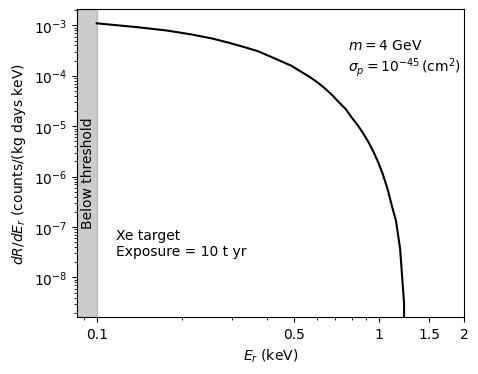

In [51]:
fig, ax = plt.subplots(figsize = (5,4))
ax.plot(nr.E, nr.diffRate(mdm0, σp0, nr.E), c = 'k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.085,2)
ylim = ax.get_ylim()
ax.fill_betweenx(ylim, 0.1, 0, color = 'grey', alpha = 0.4)
ax.set_ylim(ylim)
ax.text(0.01, 0.3, 'Below threshold', size = 10, rotation = 90, transform = ax.transAxes)
ax.set_xlabel('$E_r$ (keV)')
ax.set_ylabel('$dR/dE_r$ (counts/(kg days keV)')
ax.text(0.7, 0.8, '$m = 4$ GeV \n$\sigma_p = 10^{-45} \, (\mathrm{cm}^2)$', transform = ax.transAxes)
ax.text(0.1, 0.2, 'Xe target \nExposure = 10 t yr', transform = ax.transAxes)
ax.set_xticks([0.1, 0.5, 1, 1.5, 2], [0.1, 0.5, 1, 1.5, 2]);
plt.savefig('../Output/figures/nuclear/Differential_recoil.png',bbox_inches = 'tight', dpi = 300)

# $\Delta m_\mathrm{stat}$

In [ ]:
from tqdm.notebook import tqdm

nr = Nr('Xe', mwd['vE'], mwd['vdfE_50'], 544., 220., 0.4)

Mdm = np.logspace(0,1,100)
Sdm = np.zeros(Mdm.shape)
for i, mdm in tqdm(enumerate(Mdm)):
    Ntot_0 = nr.totN(mdm, 1e-46, nr.E, Emin = 0.1)
    if Ntot_0 == 0:
        Ntot_0 = 1e-10
    Sdm[i] = 1e-46/Ntot_0

In [ ]:
fig, ax = plt.subplots(figsize = (5,4))

ax.plot(Mdm, Sdm*3, color = 'k', lw = 1, ls = '--', label = '$N(m, \sigma_p) = 3$')
ax.fill_between(Mdm, Sdm*5, Sdm*1, color = 'k', alpha = 0.3, lw = 0, label = '$1 < N < 5$')
ax.legend(framealpha = 0)

ax.set_yscale('log')
ax.set_xlim(0,10)
ax.set_ylim(1e-48,1e-44)

ax.set_xlabel('$m$ (GeV)')
ax.set_ylabel('$\sigma_p \, (\mathrm{cm}^2$)')

ax.text(0.7, 0.5, 'Xe Targer \n$\omega$ = 1 $\mathrm{t\,\,yr}$ \n$E_\mathrm{thr}$ = 0.1 keV', transform = ax.transAxes)

ax.set_title('$\Delta m_\mathrm{stat}$')

# $\Delta m_\mathrm{MW}$

In [ ]:
mwd.keys()

In [ ]:
mwd['vdfEs'].shape

In [ ]:
for i, mdm in tqdm(enumerate(Mdm)):
    Ntot_0 = nr.totN(mdm, 1e-46, nr.E, Emin = 0.1)
    if Ntot_0 == 0:
        Ntot_0 = 1e-10
    Sdm[i] = 1e-46/Ntot_0

In [ ]:
chain_len = mwd['vdfEs'].shape[0]
Mdm = np.logspace(0,1,50)

Dm_MW = {}
for i in tqdm(range(0, chain_len, 5)):
    
    nr = Nr('Xe', mwd['vE'], mwd['vdfEs'][i], mwd['vescs'][i],
            mwd['vcircs'][i], rhosun = mwd['rhosuns'][i])
    Sdm = np.zeros(Mdm.shape)
    
    for j, mdm in enumerate(Mdm):
        Ntot_0 = nr.totN(mdm, 1e-46, nr.E, Emin = 0.1)
        Ntot_0 = 1e-10 if Ntot_0 == 0 else Ntot_0
        Sdm[j] = 1e-46/Ntot_0
        
    Dm_MW[f'{i}'] = Sdm

In [ ]:
fig, ax = plt.subplots(figsize = (5,4))

for i in range(0, chain_len, 5):
    Sdm = Dm_MW[f'{i}']
    ax.plot(Mdm, Sdm, c = 'r', alpha = 0.2, lw = 0.5)

ax.set_yscale('log')
ax.set_ylim(1e-48,1e-44)